In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import matplotlib
import matplotlib.font_manager

In [2]:
#缓存（cache）装饰器
from requests import get
from functools import wraps

def check_cache(f):
    @wraps(f)
    def wrapper(src:str, dst:str, min_size=100) -> Path:
        url = Path(src) 
        fn  = url.name  
        dsn = Path(f"{dst}/{fn}") 
        if dsn.is_file() and dsn.stat().st_size > min_size:
            print(f"+ {dsn} found locally!")
            return(dsn)
        else:
            print(f"+ {dsn} not found, downloading!")
            return(f(src, dsn))
    return wrapper

In [3]:
#下载函数
@check_cache
def cache_data(src:Path, dst:Path) -> str:
    """Downloads a remote file.
    Returns
    -------
    str
        A string representing the local location of the file.
    """
      
    # Create...
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True, exist_ok=True)
        
    # Download and write the file
    with dst.open(mode='wb') as file:
        response = get(src)
        file.write(response.content)
        
    print(' + Done downloading...')

    return dst.resolve()

In [4]:
help(cache_data)

Help on function cache_data in module __main__:

cache_data(src: pathlib.Path, dst: pathlib.Path) -> str
    Downloads a remote file.
    Returns
    -------
    str
        A string representing the local location of the file.



In [5]:
#下载/读取地理数据
ddir  = Path('data/geo')
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath + 'Boroughs.gpkg?raw=true', ddir.resolve()) )

print('Done.')

+ /home/jovyan/work/The-Universe-s-Premier-F/data/geo/Boroughs.gpkg?raw=true found locally!
Done.


/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File /home/jovyan/work/The-Universe-s-Premier-F/data/geo/Boroughs.gpkg?raw=true has GPKG application_id, but non conformant file extension
  return ogr_read(


In [6]:
# Input: date + city
ymd  = '20250615'
city = 'London'
host = "https://raw.githubusercontent.com"
repo = "yjzhou217/The-Universe-s-Premier-F/main"

url  = f"{host}/{repo}/{ymd}-{city}-listings.csv.gz"
print(url)

# 创建 data/raw 文件夹
Path("data/raw").mkdir(parents=True, exist_ok=True)

# load csv
file_path = cache_data(url, Path("data/raw").resolve())

df = pd.read_csv(file_path, compression="gzip", low_memory=False)
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")


https://raw.githubusercontent.com/yjzhou217/The-Universe-s-Premier-F/main/20250615-London-listings.csv.gz
+ /home/jovyan/work/The-Universe-s-Premier-F/data/raw/20250615-London-listings.csv.gz found locally!
Data frame is 96,651 x 79


In [7]:
#clean csv data
#testing mode
TESTING = True

if TESTING:
    N = 10_000
else:
    N = None  # None = read all

df = pd.read_csv(
    file_path,
    nrows=N,
    low_memory=False
)

print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 10,000 x 79


In [8]:
#随机抽样
df.sample(3, random_state=42)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
6252,8880178,https://www.airbnb.com/rooms/8880178,20250610032232,2025-06-11,city scrape,Bright Double bedroom close / rail station shops,The rooms are located in a flat within 2 minut...,Forest Gate is fine the flat is situated close...,https://a0.muscache.com/pictures/a727da84-99ee...,46461524,...,4.91,4.68,4.75,NaN,f,2,0,2,0,0.90
4684,6908299,https://www.airbnb.com/rooms/6908299,20250610032232,2025-06-13,previous scrape,5 Mins from Broadway Market,A lovely end of terrace period property that s...,The area is popular with artists and creatives...,https://a0.muscache.com/pictures/6316597b-aa44...,26021013,...,5.00,4.92,4.75,NaN,f,1,1,0,0,0.13
1731,2248282,https://www.airbnb.com/rooms/2248282,20250610032232,2025-06-13,previous scrape,Trendy Islington,2 minute walk to an abundance of cafes restau...,NaN,https://a0.muscache.com/pictures/30255077/5367...,11468991,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN


In [9]:
#clean data
#删除id缺失的行
missing_id_rows = df[df['id'].isna()][['id', "latitude", "longitude", 'room_type']]
print(f"{missing_id_rows.shape[0]:,}")
if missing_id_rows.shape[0] > 0:
    print(missing_id_rows.head())

df.drop(df[df['id'].isna()].index, axis=0, inplace=True)
print(f"{df.shape[0]:,} x {df.shape[1]}")

0
10,000 x 79


In [10]:
#寻找垃圾列
df.isnull().sum(axis=0).sort_values(ascending=False)[:12]

license                         10000
calendar_updated                10000
neighbourhood_group_cleansed    10000
bathrooms                        6617
beds                             6608
estimated_revenue_l365d          6602
price                            6602
host_response_rate               6506
host_response_time               6506
host_acceptance_rate             6145
neighborhood_overview            3546
neighbourhood                    3546
dtype: int64

In [11]:
#删除全是nan的列
df.drop(columns=['license','calendar_updated','neighbourhood_group_cleansed'], inplace=True)

In [12]:
#寻找垃圾行
df.isnull().sum(axis=1).sort_values(ascending=False).head(10)

5155    33
6122    33
4622    33
3646    32
5535    31
202     25
1201    25
627     25
451     25
568     24
dtype: int64

<class 'pandas.core.series.Series'>


<Axes: ylabel='Frequency'>

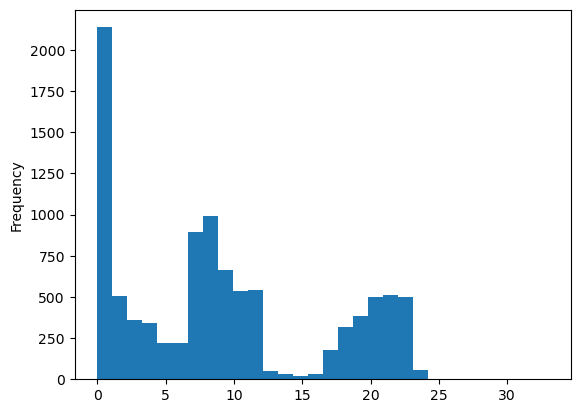

In [13]:
#绘制 histogram
probs = df.isnull().sum(axis=1)
print(type(probs))
probs.plot.hist(bins=30)

In [14]:
#考虑删除缺失超过23个值的行
print(f"df contains {df.shape[0]:,} rows.")
cutoff = 25
df.drop(probs[probs > cutoff].index, inplace=True)
print(f"df contains {df.shape[0]:,} rows.")

df contains 10,000 rows.
df contains 9,995 rows.


In [ ]:
#Fixing Data Types


In [15]:
#输出clean完的data
clean_path = f"clean/{ymd}-clean-listings.csv.gz"
df.to_csv(clean_path, index=False, compression="gzip")

OSError: Cannot save file into a non-existent directory: 'clean'